In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil, floor

In [2]:
df = pd.read_csv(os.path.join(os.path.abspath('../data'), 'houses_to_rent_v2.csv'))

### Wrong Values

As we've seen in the EDA, floor column appears to have '-' values. Let's check deeper.

In [3]:
df.loc[df['floor'] == '-'].head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
5,São Paulo,376,3,3,7,-,acept,not furnished,0,8000,834,121,8955
15,Campinas,330,4,6,6,-,acept,furnished,680,8000,328,121,9129
19,São Paulo,600,4,5,6,-,acept,not furnished,0,12000,9500,181,21680
20,São Paulo,100,7,4,0,-,acept,not furnished,0,3800,118,58,3976
23,São Paulo,35,1,1,0,-,acept,not furnished,0,1100,3,14,1117


In [4]:
df.loc[df['floor'] != '-']['floor'].astype(int).describe()

count    8231.000000
mean        6.583283
std         6.153925
min         1.000000
25%         2.000000
50%         5.000000
75%         9.000000
max       301.000000
Name: floor, dtype: float64

In [5]:
df['floor'].describe()

count     10692
unique       35
top           -
freq       2461
Name: floor, dtype: object

In [6]:
# Since there are no other variable that have connection with floor and we don't know if floor it is a variable that we will use to train the model, let's fill it with the mean of the values.

df['floor'] = df['floor'].replace({'-': np.nan})
# we have to transform to float since np.nan it's a flot number
df['floor'] = df['floor'].astype(float)
# them, we fill the nan values with the mean. The mean it's a float number, but there are no float floor, it's a integer. So, we use ceil and floor in order to transform it to a integer.
df['floor'] = df['floor'].fillna(ceil(df['floor'].mean()) if df['floor'].mean() % 2 > 0.5 else floor(df['floor'].mean()))
# finally, let's transform the floor to int
df['floor'] = df['floor'].astype('int64')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 10692 non-null  object
 1   area                 10692 non-null  int64 
 2   rooms                10692 non-null  int64 
 3   bathroom             10692 non-null  int64 
 4   parking spaces       10692 non-null  int64 
 5   floor                10692 non-null  int64 
 6   animal               10692 non-null  object
 7   furniture            10692 non-null  object
 8   hoa (R$)             10692 non-null  int64 
 9   rent amount (R$)     10692 non-null  int64 
 10  property tax (R$)    10692 non-null  int64 
 11  fire insurance (R$)  10692 non-null  int64 
 12  total (R$)           10692 non-null  int64 
dtypes: int64(10), object(3)
memory usage: 1.1+ MB


### Outliers

In the EDA, we have discovered that hoa, property tax, area and maybe rent amount have outliers. To deal with them, we are going to use the interquartile range.

We are going to check the fence in each city, in order to get the specificities on each one.

In [8]:
def iqr(df, column):
    """
    This function return the dataframe without the outliers. It uses the interquartile range for the column passed in the argument.
    """
    data = df.copy()
    city_group = data.groupby('city')[column]

    Q1 = city_group.quantile(.25)
    Q3 = city_group.quantile(.75)

    # IQR = Interquartile Range
    IQR = Q3 - Q1

    # Limits
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # DataFrame to store the new data
    new_data = pd.DataFrame()

    for city in city_group.groups.keys():
        is_city = data['city'] == city
        accepted_limit = ((data[column] >= lower[city]) &
                        (data[column] <= upper[city]))
        
        select = is_city & accepted_limit
        data_select = data[select]
        new_data = pd.concat([new_data, data_select])

    return new_data

Since we are going to do it for every single column, let's use our business knowledge and let's do for the most extreme to the least extreme values, in order to preserve data if possible.

In [9]:
df.describe()

,area,rooms,bathroom,parking spaces,floor,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
count,10692.000000,10692.000000,10692.000000,10692.000000,10692.000000,1.069200e+04,10692.000000,10692.000000,10692.000000,1.069200e+04
mean,149.217920,2.506079,2.236813,1.609147,6.679199,1.174022e+03,3896.247194,366.704358,53.300879,5.490487e+03
std,537.016942,1.171266,1.407198,1.589521,5.402218,1.559231e+04,3408.545518,3107.832321,47.768031,1.648473e+04
min,11.000000,1.000000,1.000000,0.000000,1.000000,0.000000e+00,450.000000,0.000000,3.000000,4.990000e+02
25%,56.000000,2.000000,1.000000,0.000000,3.000000,1.700000e+02,1530.000000,38.000000,21.000000,2.061750e+03
50%,90.000000,2.000000,2.000000,1.000000,7.000000,5.600000e+02,2661.000000,125.000000,36.000000,3.581500e+03
75%,182.000000,3.000000,3.000000,2.000000,8.000000,1.237500e+03,5000.000000,375.000000,68.000000,6.768000e+03
max,46335.000000,13.000000,10.000000,12.000000,301.000000,1.117000e+06,45000.000000,313700.000000,677.000000,1.120000e+06


In [10]:
# Let's create a function to see how much our standard deviation represent of the mean

def deviate_from_mean(df):
    data = df.copy()
    columns = ['area', 'hoa (R$)', 'property tax (R$)', 'rent amount (R$)']
    for column in columns:
        # print(f'The Standard Deviation of {column} represents {round((data[column].std() - data[column].mean()) / data[column].mean() * 100, 2)}% of the mean')
        print(f'The Standard Deviation of {column} represents {round(data[column].std() / data[column].mean() * 100, 2)}% of the mean')

In [11]:
deviate_from_mean(df)

The Standard Deviation of area represents 359.89% of the mean
The Standard Deviation of hoa (R$) represents 1328.11% of the mean
The Standard Deviation of property tax (R$) represents 847.5% of the mean
The Standard Deviation of rent amount (R$) represents 87.48% of the mean


The most visible outliers are:

1. hoa
2. property tax
3. area
4. rent amount

In [12]:
df = iqr(df, 'hoa (R$)')

In [13]:
deviate_from_mean(df)

The Standard Deviation of area represents 390.11% of the mean
The Standard Deviation of hoa (R$) represents 109.09% of the mean
The Standard Deviation of property tax (R$) represents 985.43% of the mean
The Standard Deviation of rent amount (R$) represents 87.03% of the mean


Now, let's do for property tax.

In [14]:
df = iqr(df, 'property tax (R$)')

In [15]:
deviate_from_mean(df)

The Standard Deviation of area represents 140.58% of the mean
The Standard Deviation of hoa (R$) represents 104.15% of the mean
The Standard Deviation of property tax (R$) represents 126.46% of the mean
The Standard Deviation of rent amount (R$) represents 83.5% of the mean


Apparently, there are no more outliers and there's no need to do it for other columns. Let's double check.

In [16]:
df.describe()

,area,rooms,bathroom,parking spaces,floor,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
count,9350.000000,9350.000000,9350.000000,9350.000000,9350.000000,9350.000000,9350.000000,9350.000000,9350.000000,9350.000000
mean,115.445134,2.330481,1.978717,1.357540,6.535401,723.550267,3276.711016,192.768021,44.566524,4237.775508
std,162.293992,1.074148,1.187555,1.362429,5.494421,753.573868,2736.013449,243.777031,38.036449,3313.887589
min,11.000000,1.000000,1.000000,0.000000,1.000000,0.000000,450.000000,0.000000,3.000000,499.000000
25%,52.250000,1.000000,1.000000,0.000000,3.000000,170.000000,1450.000000,28.000000,20.000000,1926.500000
50%,80.000000,2.000000,2.000000,1.000000,7.000000,500.000000,2390.000000,100.000000,32.000000,3146.500000
75%,142.000000,3.000000,3.000000,2.000000,8.000000,1000.000000,4000.000000,252.000000,54.000000,5364.750000
max,12732.000000,10.000000,10.000000,10.000000,301.000000,4000.000000,30000.000000,1193.000000,451.000000,31010.000000


We can see that area and floor still have outliers.

In [17]:
df.loc[(df['floor'] > 100) | (df['area'] > 10000)]

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
2562,Belo Horizonte,80,3,2,2,301,acept,not furnished,750,2600,164,35,3549
9241,Campinas,12732,3,2,0,3,acept,not furnished,700,1600,96,21,2417


There are only two values left. Let's drop them.

In [18]:
df = df.loc[(df['floor'] < 100) & (df['area'] < 10000)]

In [19]:
df.shape

(9348, 13)

<AxesSubplot:xlabel='area'>

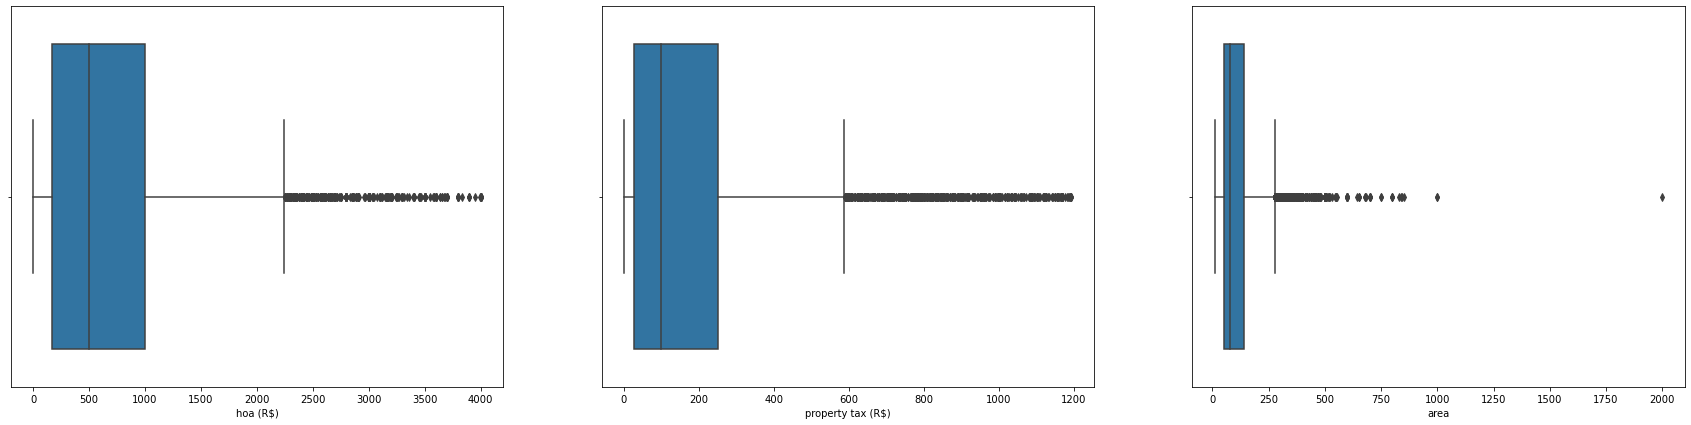

In [20]:
plt.figure(figsize=(30, 7))
plt.subplot(1, 3, 1)
sns.boxplot(x='hoa (R$)', data=df)
plt.subplot(1, 3, 2)
sns.boxplot(x='property tax (R$)', data=df)
plt.subplot(1, 3, 3)
sns.boxplot(x='area', data=df)

In [21]:
df.describe()

,area,rooms,bathroom,parking spaces,floor,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
count,9348.000000,9348.000000,9348.000000,9348.000000,9348.000000,9348.000000,9348.000000,9348.000000,9348.000000,9348.000000
mean,114.099273,2.330338,1.978712,1.357617,6.504279,723.549957,3276.962773,192.781451,44.570068,4238.043967
std,96.505123,1.074218,1.187682,1.362487,4.573413,753.654397,2736.242224,243.800874,38.039608,3314.180933
min,11.000000,1.000000,1.000000,0.000000,1.000000,0.000000,450.000000,0.000000,3.000000,499.000000
25%,52.000000,1.000000,1.000000,0.000000,3.000000,170.000000,1450.000000,28.000000,20.000000,1926.000000
50%,80.000000,2.000000,2.000000,1.000000,7.000000,500.000000,2390.000000,100.000000,32.000000,3146.500000
75%,142.000000,3.000000,3.000000,2.000000,8.000000,1000.000000,4000.000000,252.000000,54.000000,5367.000000
max,2000.000000,10.000000,10.000000,10.000000,51.000000,4000.000000,30000.000000,1193.000000,451.000000,31010.000000


Let's check the target variable.

<AxesSubplot:xlabel='rent amount (R$)'>

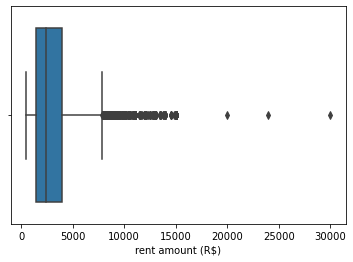

In [22]:
sns.boxplot(x='rent amount (R$)', data=df)

We can see that are three values that are way higher than others, let's check on them.

In [23]:
df[df['rent amount (R$)'] > 15000]

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
1743,São Paulo,410,4,5,5,1,acept,not furnished,0,20000,0,254,20250
2619,São Paulo,80,2,1,1,1,acept,not furnished,875,24000,0,305,25180
7748,São Paulo,350,3,3,3,7,acept,not furnished,0,30000,560,451,31010


 The first and the third value appears to be consistent, the area is high, the number of rooms, bathrooms and parking spaces seem to make sense.

The second value don't, the values are too low for this price. We will drop this value.

In [24]:
# drop by index
df = df.drop(2619)

In [25]:
df.shape

(9347, 13)

We have iniated our ETL with 10692, and now we have 9347 values. So we have dropped 1345 registers that represents 12,57% of the original data.

In [26]:
df.to_csv(os.path.join(os.path.abspath('../data'),'houses_to_rent_v2_etl.csv'), index=False)